## $\color{red}{\text{Presentation 3:}}$

### $\color{green}{\text{Part 1: Data Cleaning}}$

**Import Required Packages, Data, and Mount Drive:**

In [26]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
%cd '/content/drive/MyDrive/Data'
churn_df = pd.read_excel('churn.xlsx', sheet_name = "BankChurners")

/content/drive/MyDrive/Data


## Data Transformation

**Seperating Numeric and Categorical Data:**

In [29]:
# Numeric component of HR dataset
churn_df_num = churn_df.select_dtypes(include = np.number) # Selecting only the numeric data of the dataset // select data types and including only numbers
churn_df_num.head()

# Categorical component of HR dataset
churn_df_cat = churn_df.select_dtypes(exclude = np.number) # Selecting only the categorical data // select data types and exluding numeric
churn_df_cat.head()

,Client_Attrition,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
0,NO,M,NaN,Married,$120K+,Gold
1,NO,M,Uneducated,NaN,$120K+,Blue
2,NO,M,NaN,Married,$120K+,Blue
3,YES,M,Graduate,Married,$120K+,Blue
4,NO,M,Post-Graduate,Single,$120K+,Blue


**Missing Value Analysis:**

In [30]:
# Function to compute missing values
def percent_missing(data):
    return data.isnull().sum().divide(len(data)).sort_values(ascending=False)

# Using the function
percent_missing(churn_df).head()

Total_Revolving_Bal    0.243902
Education_Level        0.149995
Income_Category        0.109805
Marital_Status         0.073961
Credit_Limit           0.003456
dtype: float64

**Imputation: Because there are variables with more than 15% of their data missing, we are choosing to remove them**

In [31]:
# Function to do conditional deletion

def semi_listwise(data, nan_percent):
    d1 = data.isnull().sum().divide(len(data)).sort_values(ascending=False)
    culprit_vars = []
    for i in range(len(d1.values)):
        if(d1.values[i] >= nan_percent):
            culprit_vars.append(d1.index[i])
    return data[data.columns.difference(culprit_vars)]

In [32]:
delCol15_num = semi_listwise(churn_df_num, 0.15) # Deleting all columns with 15% missing data
delCol15_cat = semi_listwise(churn_df_cat, 0.15)
# Check if deletion worked
print(churn_df_num.shape) # Printing shape of original data
print(delCol15_num.shape) # Printing shape of deleted columns

(10127, 15)
(10127, 14)


In [33]:
print(churn_df_cat.shape)
print(delCol15_cat.shape)

(10127, 6)
(10127, 6)


In [34]:
# Find the median for numeric component
col_med = delCol15_num.median() # calculating the median for each column
# print(col_med) # Printing the medians for each column

# Now inpute missing data with the median
churn_df_full = delCol15_num.fillna(col_med) # Filling in missing data with the median for each column

# Now check if data is missing
percent_missing(churn_df_full)

Age                      0.0
Avg_Open_To_Buy          0.0
Avg_Utilization_Ratio    0.0
Client_ID                0.0
Contacts_In12Mon         0.0
Credit_Limit             0.0
Dependent_Count          0.0
Inactive_In12Mon         0.0
Months_With_Bank         0.0
Products_By_Clients      0.0
Total_Amt_Chng_Q4_Q1     0.0
Total_Ct_Chng_Q4_Q1      0.0
Total_Trans_Amt          0.0
Total_Trans_Ct           0.0
dtype: float64

In [35]:
print(delCol15_cat)

      Client_Attrition Gender Education_Level Marital_Status Income_Category  \
0                   NO      M             NaN        Married          $120K+   
1                   NO      M      Uneducated            NaN          $120K+   
2                   NO      M             NaN        Married          $120K+   
3                  YES      M        Graduate        Married          $120K+   
4                   NO      M   Post-Graduate         Single          $120K+   
...                ...    ...             ...            ...             ...   
10122              YES      F        Graduate        Married             NaN   
10123              YES      F       Doctorate         Single             NaN   
10124               NO      F      Uneducated        Married             NaN   
10125              YES      F        Graduate        Married             NaN   
10126              YES      F      Uneducated         Single             NaN   

      Card_Category  
0              Go

In [36]:
# Find the mode for categorical component
col_mode = delCol15_cat.mode()  # calculating the mode for each column
# print(col_mode)  # Printing the modes for each column

# Now impute missing data with the mode
churn_df_full_2 = delCol15_cat.apply(lambda x: x.fillna(x.mode()[0]))

# Now check if data is missing
percent_missing(churn_df_full_2)


Client_Attrition    0.0
Gender              0.0
Education_Level     0.0
Marital_Status      0.0
Income_Category     0.0
Card_Category       0.0
dtype: float64

In [37]:
churn_df_full_2.head()

,Client_Attrition,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
0,NO,M,Graduate,Married,$120K+,Gold
1,NO,M,Uneducated,Married,$120K+,Blue
2,NO,M,Graduate,Married,$120K+,Blue
3,YES,M,Graduate,Married,$120K+,Blue
4,NO,M,Post-Graduate,Single,$120K+,Blue


**Addressing Multicolinearity:**

In [40]:
#!pip install dython
from dython.nominal import associations
import seaborn as sns

def corrPlot(data):

  # Use "associations" function to compute correlation between all variables
  corr_matrix = associations(dataset=data, compute_only=True)['corr']

  # Mask the upper triangle of correlation heatmap
  mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Plotting correlation heatmap
  plt.figure(figsize=(12, 8))
  sns.heatmap(corr_matrix, annot=True, mask=mask_upper, cmap='coolwarm_r', fmt='.2f', vmin=-1, vmax=1)
  plt.show()

In [41]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance
'''

def drop_highly_correlated(data, threshold):
    cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): to_drop.append(var1)
        else: to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1)

/usr/local/lib/python3.10/dist-packages/dython/nominal.py:736: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]] = _inf_nan_str(ij)
/usr/local/lib/python3.10/dist-packages/dython/nominal.py:737: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[j], columns[i]] = _inf_nan_str(ji)
/usr/local/lib/python3.10/dist-packages/dython/nominal.py:736: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  inf_nan.loc[columns[i], columns[j]]

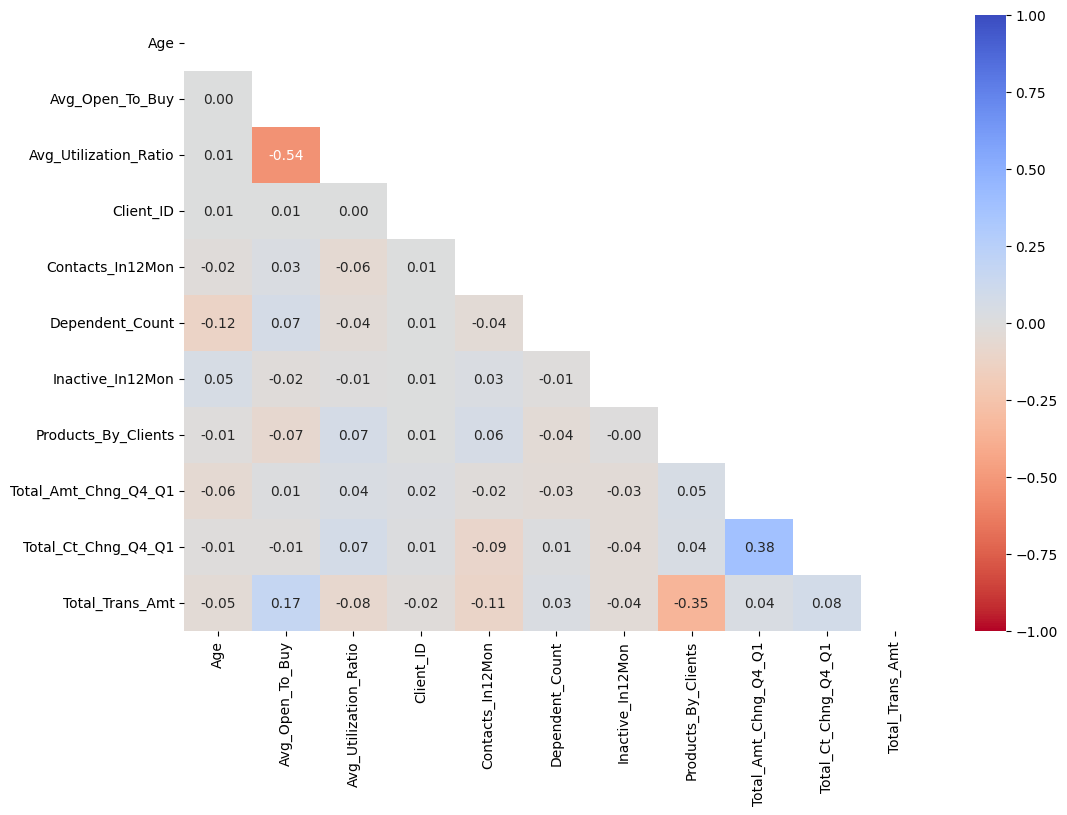

In [42]:
# use the t function to remove variables with high correlation
dropped_vars, churn_new_v2 = drop_highly_correlated(data = churn_df_full, threshold = 0.7)

# Plot the correlation of the resulting data
corrPlot(data = churn_new_v2)

In [43]:
delCol15_num.head()

,Age,Avg_Open_To_Buy,Avg_Utilization_Ratio,Client_ID,Contacts_In12Mon,Credit_Limit,Dependent_Count,Inactive_In12Mon,Months_With_Bank,Products_By_Clients,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct
0,51,32252.0,0.066,810347208,3,34516.0,4,1,46,6,1.975,0.722,1330,31
1,42,5281.0,0.217,708790833,2,6748.0,5,3,31,5,0.831,0.680,1201,42
2,49,17246.0,0.127,712813458,0,19763.0,2,2,36,4,0.664,0.250,1414,35
3,56,15769.0,0.000,714374133,3,15769.0,2,3,36,1,1.041,0.364,602,15
4,44,21855.0,0.088,710082708,2,23957.0,4,4,32,2,0.997,0.733,1276,26


Removing Near Zero Variance Variables:

In [44]:
from sklearn.feature_selection import VarianceThreshold

vThreshold = VarianceThreshold(threshold = 0.1)
vThreshold.fit_transform(churn_new_v2)

# Get variables with greater variance
vars = churn_new_v2.columns[vThreshold.get_support()]

# Subset data for variables with greater variance
churn_varDf = churn_new_v2[vars]

# Dropping 'Client_ID' as it is not needed for analysis
new_churn_var_df = churn_varDf.drop(columns = ['Client_ID'])

Standardization:

In [45]:
churn_new = pd.concat([new_churn_var_df, churn_df_full_2], axis = 1)
churn_new.head()

,Age,Avg_Open_To_Buy,Contacts_In12Mon,Dependent_Count,Inactive_In12Mon,Products_By_Clients,Total_Trans_Amt,Client_Attrition,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
0,51,32252.0,3,4,1,6,1330,NO,M,Graduate,Married,$120K+,Gold
1,42,5281.0,2,5,3,5,1201,NO,M,Uneducated,Married,$120K+,Blue
2,49,17246.0,0,2,2,4,1414,NO,M,Graduate,Married,$120K+,Blue
3,56,15769.0,3,2,3,1,602,YES,M,Graduate,Married,$120K+,Blue
4,44,21855.0,2,4,4,2,1276,NO,M,Post-Graduate,Single,$120K+,Blue


In [46]:
from sklearn.preprocessing import StandardScaler

# Standardize data // comparing variables 'apples to apples'
churn_std = StandardScaler().fit_transform(new_churn_var_df)
# Transforms churn_std into a data frame and getting column names instead of numbers
churn_stdDf = pd.DataFrame(churn_std, columns = new_churn_var_df.columns)

# Bring the dependent variable to the standardized data // do NOT standardize dependent variable
churn_std_full = pd.concat([churn_stdDf, churn_df['Avg_Utilization_Ratio']], axis = 1)

Data Partitoning:

In [47]:
from sklearn.model_selection import train_test_split

# Independent variables used for regression
depVar = churn_std_full['Avg_Utilization_Ratio']

# Exclude 'Avg_Utilization_Ratio' column
indVar = churn_std_full.drop(columns=['Avg_Utilization_Ratio'])

# Partition data into training(70%) and testing(30%).
trainX, testX, trainY, testY = train_test_split(indVar, depVar, test_size = 0.3, random_state = 1)

In [50]:
#!pip install feature_engine
from feature_engine.encoding import MeanEncoder

# Mean encoding
mean_enc=MeanEncoder().fit(trainX,trainY)

# obtain new train and testing data with the categorical variables replaced with mean of dependent variable
new_train=mean_enc.transform(trainX)
new_test=mean_enc.transform(testX)

TypeError: No categorical variables found in this dataframe. Please check variable format with pandas dtypes.

### $\color{green}{\text{Part 2: Modeling}}$

## $\color{blue}{\text{Linear Regression}}$

### $\color{white}{\text{Multiple Linear Regression Model Training and Output}}$

In [51]:
import statsmodels.api as sm

#add the intercept term to the data
trainX = sm.add_constant(trainX)

#Model with training data
mlr_model = sm.OLS(trainY, trainX).fit()

#print the model summary
print(mlr_model.summary())

                              OLS Regression Results                             
Dep. Variable:     Avg_Utilization_Ratio   R-squared:                       0.293
Model:                               OLS   Adj. R-squared:                  0.292
Method:                    Least Squares   F-statistic:                     419.4
Date:                   Sat, 20 Apr 2024   Prob (F-statistic):               0.00
Time:                           18:47:58   Log-Likelihood:                 289.39
No. Observations:                   7088   AIC:                            -562.8
Df Residuals:                       7080   BIC:                            -507.8
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
cons

In [52]:
trainX.isnull().sum()

const                  0
Age                    0
Avg_Open_To_Buy        0
Contacts_In12Mon       0
Dependent_Count        0
Inactive_In12Mon       0
Products_By_Clients    0
Total_Trans_Amt        0
dtype: int64

**Residual Analysis and QQ Plot for MLR:**

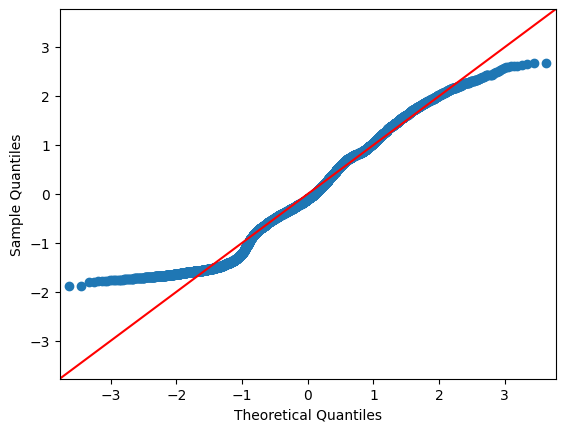

In [53]:
import scipy.stats as stats

# Residual for mlr
res_mlr = mlr_model.resid
fig = sm.qqplot(res_mlr, stats.t, fit = True, line = '45')
plt.show()

**Model Prediction: Predict the Avg_Utilization_Ratio of the testing data as a function of the independent variables**

In [57]:
# Add constant to the testing data
testX = sm.add_constant(testX)

# Predict for multiple linear regression
mlr_pred = mlr_model.predict(testX.drop(columns=['Avg_Utilization_Ratio']))

KeyError: "['Avg_Utilization_Ratio'] not found in axis"

## **Quantile Regression**

Quantile Regression Model and Output:

In [56]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

#add dependent variable back in to train x for quantile regression
# Define the formula correctly
trainXqr = trainX.drop(columns = ["Avg_Utilization_Ratio"])

reg_formula = 'Avg_Utilization_Ratio ~ ' + '+'.join(trainXqr.columns)

# Build the quantile regression model
quant_reg = smf.quantreg(reg_formula, trainX).fit(q=0.5)

# Print results
print(quant_reg.summary())

KeyError: "['Avg_Utilization_Ratio'] not found in axis"

Model Prediction:

In [58]:
# Get predicted house prices for the quantile regression
qr_pred_test = quant_reg.predict(testX)

NameError: name 'quant_reg' is not defined

# **Lasso Regression:**

Model Fitting and Result

In [59]:
# Add the intercept term to the data before modeling
trainX = sm.add_constant(trainX)

# LASSO modeling (As alpha increases, the coefficients shrink to zero. L1_wt = 1 means lasso regression)
# Alpha must yield a smaller error.
lasso_model = sm.OLS(trainY, trainX.drop(columns = ['Avg_Utilization_Ratio'])).fit_regularized(alpha = 0.01, L1_wt = 1)

# Print model coefficients
lasso_model.params

KeyError: "['Avg_Utilization_Ratio'] not found in axis"

Model Prediction:

In [60]:
# Always performed on testing data.
# Add the intercept term to the data before modeling
testX = sm.add_constant(testX)

# Predict housing prices based on testing data.
lasso_pred_test = lasso_model.predict(testX.drop(columns = ['Avg_Utilization_Ratio']))

NameError: name 'lasso_model' is not defined

QQ Plot:

In [61]:
import scipy.stats as stats

residual = testY - lasso_pred_test
fig = sm.qqplot(residual, stats.t, fit = True, line = '45')
plt.show()

NameError: name 'lasso_pred_test' is not defined

## Decision Tree and Random Forest Regression

### Model Fitting and Result


In [63]:
#!pip install dmba
from dmba import plotDecisionTree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Create a decision tree and random forest model
dt_model = DecisionTreeRegressor(random_state = 1).fit(trainX.drop(columns = ['Avg_Utilization_Ratio']), trainY)
rf_model = RandomForestRegressor(random_state = 1).fit(trainX.drop(columns = ['Avg_Utilization_Ratio']), trainY)

KeyError: "['Avg_Utilization_Ratio'] not found in axis"

In [64]:
# Plot the decision tree model
column_names = trainXqr.columns
plotDecisionTree(dt_model, feature_names = column_names)

NameError: name 'trainXqr' is not defined

### $\color{blue}{\text{Model Predictions}}$

- Using the **testing data**, predict the **Avg_Utilization_Ratio**
  - This is prediction on unseen data

In [65]:
# Get Avg_Utilization_Ratio predictions
dt_pred = dt_model.predict(testX.drop(columns = ['Avg_Utilization_Ratio']))
rf_pred = dt_model.predict(testX.drop(columns = ['Avg_Utilization_Ratio']))

NameError: name 'dt_model' is not defined

### $\color{blue}{\text{QQ Plot}}$

In [66]:
import statsmodels.api as sm
import scipy.stats as stats

# Get residuals for decision tree and rf models
dt_res = testY - dt_pred
rf_res = testY - rf_pred

# Decision Tree Plot
fig = sm.qqplot(dt_res, stats.t, fit = True, line = '45')
plt.show()

NameError: name 'dt_pred' is not defined

In [67]:
# Random Forest Plots
fig = sm.qqplot(rf_res, stats.t, fit = True, line = '45')
plt.show()

NameError: name 'rf_res' is not defined

## $\color{red}{\text{KNN *Regression*}}$

### $\color{blue}{\text{Model Fitting and Result}}$

In [68]:
from sklearn.neighbors import KNeighborsRegressor

# Creating the model
knn_model = KNeighborsRegressor(n_neighbors = 2, n_jobs = -1).fit(trainX, trainY)

### $\color{blue}{\text{Model Predictions}}$

- Using the **testing data**, predict the **Avg_Utilization_Ratio**
  - This is prediction on unseen data

In [69]:
# Get Avg_Utilization_Ratio predictions
knn_pred = knn_model.predict(testX)

### $\color{blue}{\text{QQ Plot}}$

In [70]:
# Getting residuals
knn_res = testY - knn_pred

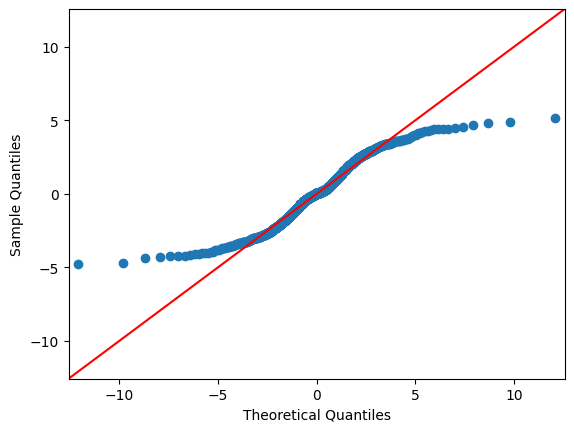

In [71]:
# QQ-plot
fig = sm.qqplot(knn_res, stats.t, fit = True, line = '45')

## $\color{red}{\text{RMSE}}$
### $\color{blue}{\text{Quantile Regression}}$

In [72]:
# !pip install dmba
from dmba import regressionSummary

# Compute the regression diagnostics
print("***************Testing Data***************")
regressionSummary(testX['Avg_Utilization_Ratio'], qr_pred_test)

***************Testing Data***************


KeyError: 'Avg_Utilization_Ratio'

### $\color{blue}{\text{MLR}}$

In [73]:
# Compute the regression diagnostics
print("***************Testing Data***************")
regressionSummary(testX['Avg_Utilization_Ratio'], mlr_pred)

***************Testing Data***************


KeyError: 'Avg_Utilization_Ratio'

### $\color{blue}{\text{LASSO Regression}}$

In [74]:
# get model diagnostic measures
regressionSummary(testY, lasso_pred_test)

NameError: name 'lasso_pred_test' is not defined

### $\color{blue}{\text{Decision Tree Regression}}$

In [75]:
# Compute common regression diagnostics
print("******************** DECISION TREES ********************")
regressionSummary(testY, dt_pred)

******************** DECISION TREES ********************


NameError: name 'dt_pred' is not defined

### $\color{blue}{\text{Random Forest Regression}}$

In [76]:
# Compute common regression diagnostics
print("******************** RANDOM FOREST ********************")
regressionSummary(testY, rf_pred)

******************** RANDOM FOREST ********************


NameError: name 'rf_pred' is not defined

### $\color{blue}{\text{KNN Regression}}$

In [77]:
# Compute common regression diagnostics
print("******************** KNN REGRESSION ********************")
regressionSummary(testY, knn_pred)

******************** KNN REGRESSION ********************

Regression statistics

               Mean Error (ME) : -0.0058
Root Mean Squared Error (RMSE) : 0.2606
     Mean Absolute Error (MAE) : 0.1863
